In [11]:
# Data manipulation and analysis
import pandas as pd
import numpy as np
from scipy import sparse, special, stats

# Machine Learning
from sklearn.metrics import (
    mean_squared_error,
    roc_curve,
    roc_auc_score,
    accuracy_score
)
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from scipy.special import softmax

# Parallel Processing
from joblib import Parallel, delayed
from concurrent.futures import ThreadPoolExecutor, as_completed
from functools import partial

# Data Structure and Iteration
from collections import defaultdict
from itertools import combinations, permutations

# Visualization
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# System and Utilities
import os
import re
import random
import warnings
import contextlib
import itertools
from typing import List, Set, Dict, Tuple, Optional
import json

from catboost import CatBoostClassifier, Pool
from sklearn.metrics import roc_auc_score
import numpy as np
from sklearn.preprocessing import label_binarize
from sklearn.metrics import accuracy_score

# Grove
import sys
sys.path.append('../src')
from grove_model import Grove_multi

# 데이터 불러오기 (TMAS 데이터)

In [12]:
# TMAS
url = 'https://github.com/novicedata/Paper/blob/main/Grove_CAT/data/TMA.csv?raw=true'
data = pd.read_csv(url)

In [13]:
data

,score,gender,age,Q1,Q2,Q3,Q4,Q5,Q6,Q7,...,Q41,Q42,Q43,Q44,Q45,Q46,Q47,Q48,Q49,Q50
0,32,2,56,2,2,2,1,2,1,2,...,2,1,1,1,2,1,1,1,2,2
1,17,1,30,1,2,1,1,2,1,1,...,1,1,2,2,2,2,2,2,2,2
2,41,1,32,2,1,1,2,1,1,1,...,1,1,1,2,1,1,2,1,1,2
3,31,1,29,1,2,2,1,1,1,1,...,1,2,1,1,1,1,1,2,1,2
4,35,1,23,1,2,2,1,1,2,1,...,2,1,1,1,1,1,2,1,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5405,35,1,27,2,2,2,2,1,1,2,...,1,1,1,1,1,1,1,1,1,2
5406,31,2,24,1,2,2,1,1,1,0,...,1,1,1,2,1,1,1,1,2,2
5407,4,1,22,1,2,1,1,2,2,2,...,2,2,2,1,2,2,2,2,2,1
5408,41,1,16,1,2,1,2,1,1,1,...,1,1,1,1,1,1,1,1,2,2


# 데이터 정제

선행연구에 따라 점수를 총 4개의 클래스 레이블로 지정

In [14]:
# TMA
# gender가 3 또는 0인 행 제거
data.drop(data[(data['gender'] == 3) | (data['gender'] == 0)].index, inplace=True)

# age가 14세 미만 또는 80세 초과인 행 제거
data.drop(data[(data['age'] < 14) | (data['age'] > 80)].index, inplace=True)

# 0값이 있는 행 제거 (Q1~Q50 컬럼에서)
for col in data.columns[4:54]:  # Q1~Q50에 해당하는 컬럼들
    data.drop(data[data[col] == 0].index, inplace=True)

data.reset_index(inplace=True, drop=True)  # 인덱스 리셋

# 필요한 컬럼만 남김 (Q1 ~ Q50)
X = data.iloc[:, 3:55]
y = data['score']

# 라벨링 함수 정의
def label_anxiety(score):
    if 5 <= score <= 15:
        return 'low anxiety'
    elif 15 < score <= 39:
        return 'moderate anxiety'
    elif 40 <= score <= 50:
        return 'severe anxiety'
    else:
        return 'no anxiety'  # 점수가 지정된 범위에 없는 경우

# y 값에 라벨링 적용
y = y.apply(label_anxiety)

In [15]:
y.value_counts()

score
moderate anxiety    3054
severe anxiety      1123
low anxiety          250
no anxiety            25
Name: count, dtype: int64

In [16]:
X

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,...,Q41,Q42,Q43,Q44,Q45,Q46,Q47,Q48,Q49,Q50
0,2,2,2,1,2,1,2,2,1,2,...,2,1,1,1,2,1,1,1,2,2
1,1,2,1,1,2,1,1,2,1,2,...,1,1,2,2,2,2,2,2,2,2
2,2,1,1,2,1,1,1,1,1,1,...,1,1,1,2,1,1,2,1,1,2
3,1,2,2,1,1,1,1,2,2,2,...,1,2,1,1,1,1,1,2,1,2
4,1,2,2,1,1,2,1,1,1,1,...,2,1,1,1,1,1,2,1,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4447,2,2,2,1,1,1,1,2,2,1,...,1,1,1,1,1,1,1,1,1,2
4448,2,2,2,2,1,1,2,2,2,2,...,1,1,1,1,1,1,1,1,1,2
4449,1,2,1,1,2,2,2,2,2,2,...,2,2,2,1,2,2,2,2,2,1
4450,1,2,1,2,1,1,1,1,2,2,...,1,1,1,1,1,1,1,1,2,2


### 다중 분류이기 때문에 train catboost 함수 또한 단일 분류와 다름

In [17]:
def train_catboost(X_train, y_train, X_test, y_test,
                            max_depth=3,
                            n_estimators=100,
                            learning_rate=1,
                            min_child_samples=1,
                            random_state=42,
                            auto_class_weights=None):
    """
    다중분류를 위한 CatBoost 모델을 학습시키는 함수입니다.

    :param X_train: 학습 데이터
    :param y_train: 학습 데이터의 레이블
    :param X_test: 테스트 데이터
    :param y_test: 테스트 데이터의 레이블
    :param max_depth: 트리의 최대 깊이 (default: 3)
    :param n_estimators: 생성할 트리의 수 (default: 100)
    :param learning_rate: 학습률 (default: 1)
    :param subsample: 각 트리가 사용할 데이터의 비율 (default: 0.5)
    :param min_child_samples: 리프 노드의 최소 샘플 수 (default: 1)
    :param random_state: 랜덤 시드 (default: 42)
    :param auto_class_weights: 클래스 가중치 자동 설정 (default: None)
    :return: 학습된 모델과 파라미터
    """
    # 클래스 수 확인
    n_classes = len(np.unique(y_train))

    # 모델 파라미터 설정
    params = {
        'loss_function': 'MultiClass',  # 다중분류용 손실함수
        'eval_metric': 'MultiClass',    # 다중분류용 평가지표
        'learning_rate': learning_rate,
        'grow_policy' : 'Lossguide',
        'depth': max_depth,
        'random_seed': random_state,
        'iterations': n_estimators,
        'verbose': False,
        'thread_count': -1,
        'auto_class_weights': auto_class_weights,
        'classes_count': n_classes      # 클래스 수 지정
    }

    # Pool 생성
    train_pool = Pool(data=X_train, label=y_train)
    test_pool = Pool(data=X_test, label=y_test)

    # 모델 생성 및 학습
    model = CatBoostClassifier(**params)
    model.fit(train_pool,
              eval_set=test_pool,
              verbose=False)

    # 학습 데이터에 대한 예측 및 정확도 계산
    y_pred_train = model.predict(train_pool)
    train_accuracy = accuracy_score(y_train, y_pred_train)
    print(f"Final model accuracy on train data: {train_accuracy:.4f}")

    # 테스트 데이터에 대한 예측 및 정확도 계산
    y_pred_test = model.predict(test_pool)
    test_accuracy = accuracy_score(y_test, y_pred_test)
    print(f"Final model accuracy on test data: {test_accuracy:.4f}")

    # 클래스별 확률 예측 및 ROC AUC 계산 (클래스가 3개 이상인 경우)
    if n_classes > 2:
        y_pred_proba_test = model.predict_proba(test_pool)
        # 레이블 이진화
        y_test_bin = label_binarize(y_test, classes=np.unique(y_train))

        # 클래스별 AUC 계산
        for i in range(n_classes):
            class_auc = roc_auc_score(y_test_bin[:, i], y_pred_proba_test[:, i])
            print(f"AUC for class {i}: {class_auc:.4f}")

    return model, params

### Grove 함수

다중분류 이기에 softmax 적용

나무 구조 또한 단일 분류 나무구조와 다르기 때문에 그에 맞게 코드 수정

## Fig. 8.

### 데이터 분할:

전체 데이터를 테스트 세트(20%), 학습 세트(40%), 검증 세트(40%)로 분할.
                                       

### CatBoost 모델 초기 학습:

최대 깊이 10, 트리 개수 6개의 CatBoost 모델을 학습.
학습률(learning_rate)은 1로 설정.


### 최적 임계값 계산 함수 정의:

optimal_threshold 함수는 ROC 곡선을 기반으로 최적의 분류 임계값을 찾음.
이 임계값에서의 정확도(accuracy)도 함께 계산.


### Grove 분석 수행:

Grove 클래스를 사용해 분석을 실행.
3개부터 4개까지의 트리 조합을 분석합니다.
Grove 분석 결과를 바탕으로 검증 세트와 테스트 세트에 대한 성능을 평가.
각 트리 조합별로 항목 수, AUC, 정확도를 저장.


### CatBoost 모델 추가 평가:

Grove에서 찾은 최대 항목 수까지 반복하며 다양한 트리 개수의 모델을 평가.
각 반복마다 새로운 CatBoost 모델을 지정된 트리 수로 학습.
학습 및 테스트 세트에 대한 AUC와 정확도를 계산.
최적 임계값도 함께 저장.


### Decision Tree 모델 평가:

같은 범위에서 다양한 깊이의 Decision Tree 모델을 학습.
CatBoost와 마찬가지로 성능 지표를 계산하고 저장.


### 결과 시각화:

4 개의 서브플롯으로 구성된 그래프를 생성:

상단: ROC-AUC 점수 비교 ( 왼쪽은 train/vlaid set, 오른쪽은 test set )
하단: 정확도(Accuracy) 비교 ( 왼쪽은 train/vlaid set, 오른쪽은 test set )


각 그래프에는 세 가지 모델(CatBoost, Decision Tree, Grove)의 학습/검증/테스트 성능이 표시.

x축은 "사람당 최대 항목 수"를 나타냄.

Train set size: 1780
Validation set size: 1781
Test set size: 891
Final model accuracy on train data: 0.9079
Final model accuracy on test data: 0.8765
AUC for class 0: 0.9826
AUC for class 1: 0.9538
AUC for class 2: 0.9911
AUC for class 3: 0.9717
CatBoost evaluation completed
DT model ...
Done 

Initializing analysis...
Number of trees: 6
Extracting tree features...
Step 1: Calculating predictions for each tree...
Step 2: Finding optimal tree groups...
Processed 10 batches out of 35
Processed 20 batches out of 35
Processed 30 batches out of 35
Filtered to top 35 results based on 100% percentile
Calculating min/max items for filtered results...
Processing 35 results...
Processing completed. Found 35 unique combinations.
Final Combinations : 35


/tmp/ipykernel_20823/3084987132.py:187: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap('tab20', len(unique_tree_counts))


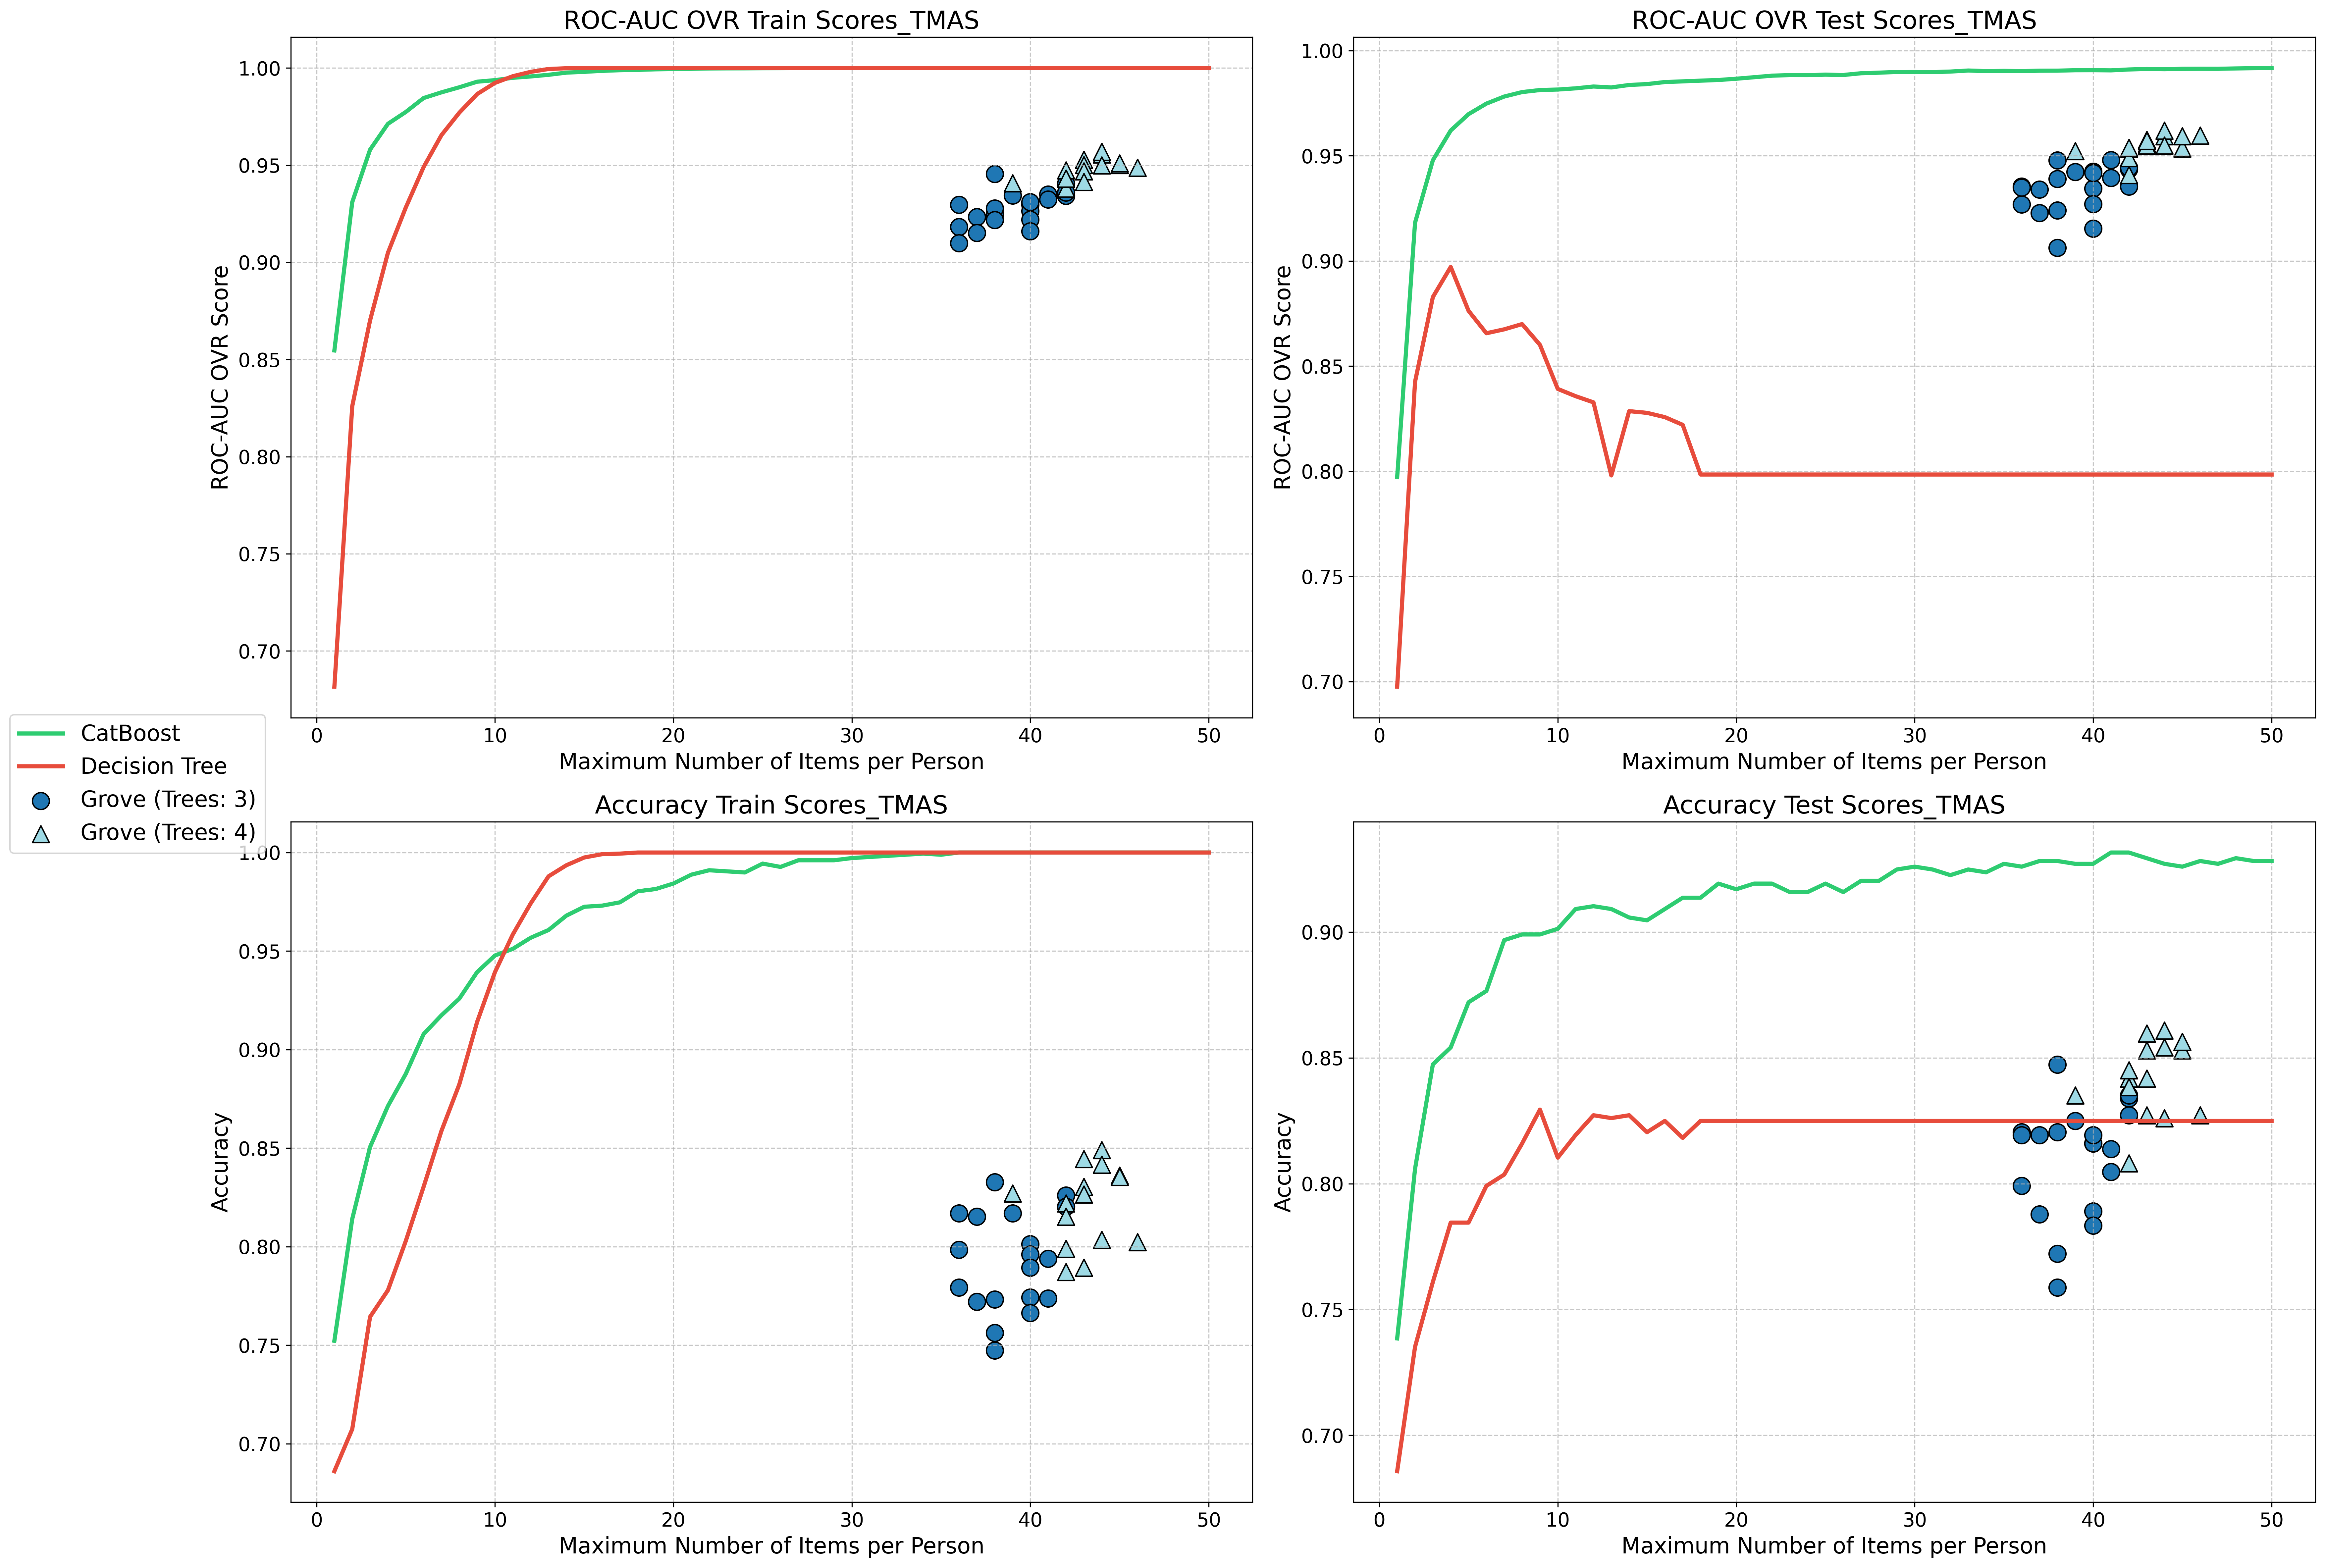

In [18]:
# 레이블 인코딩: y 값 (클래스 레이블)을 0부터 시작하는 정수로 변환
le = LabelEncoder()
y = le.fit_transform(y)
num_classes = 4  # 다중 분류 문제이므로 클래스 수를 4로 설정
grove = Grove_multi()  # Grove 객체 생성

# 데이터 분할: 20%는 테스트 데이터로 분리, 나머지 80%를 학습 및 검증 데이터로 나눈다.
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_valid, y_train, y_valid = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)
# X_temp, y_temp는 학습 및 검증용 데이터를 나누기 위한 중간 데이터

# 데이터 분할 결과 출력
print(f"Train set size: {len(X_train)}")
print(f"Validation set size: {len(X_valid)}")
print(f"Test set size: {len(X_test)}")

# CatBoost 모델 학습을 위한 하이퍼파라미터 설정
trees_num = 6  # 트리 개수
max_depth = 10  # 트리 최대 깊이

# CatBoost 모델 학습
model, param = train_catboost(X_train, y_train, X_test, y_test,
                            max_depth=max_depth,
                            n_estimators=trees_num,
                            learning_rate=1,  # 학습률
                            min_child_samples=1,
                            random_state=42,
                            auto_class_weights=None)
# CatBoost 모델을 학습, 파라미터를 `train_catboost` 함수에서 설정

# CatBoost 및 Decision Tree 평가 결과를 저장할 딕셔너리
cat_results = {
    'train_auc': {}, 'test_auc': {},
    'train_acc': {}, 'test_acc': {},
    'thresholds': {}
}

dt_results = {
    'train_auc': {}, 'test_auc': {},
    'train_acc': {}, 'test_acc': {},
    'thresholds': {}
}

# CatBoost 모델 평가
cat_models = {}
cat_pred_tests = {}

# Pool 객체 생성: CatBoost 모델 학습 및 예측을 위해 학습 데이터와 테스트 데이터를 Pool 객체로 변환
train_pool = Pool(data=X_train, label=y_train)
test_pool = Pool(data=X_test, label=y_test)

# 트리 개수에 대해 CatBoost 모델 학습 및 평가
for n_tree in range(1, 51, 1):  # 1부터 50까지 트리 개수에 대해 모델을 학습
    # 모델 학습: 트리 개수를 n_tree로 설정
    params = param.copy()
    params['iterations'] = n_tree
    cat_model = CatBoostClassifier(**params)
    cat_model.fit(train_pool, verbose=False)
    cat_models[n_tree] = cat_model

    # 예측값 계산
    y_pred_train = cat_model.predict(train_pool, prediction_type='Probability')
    y_pred_test = cat_model.predict(test_pool, prediction_type='Probability')
    cat_pred_tests[n_tree] = y_pred_test

    # AUC (One-vs-Rest)와 Accuracy 계산
    train_auc = roc_auc_score(y_train, y_pred_train, multi_class='ovr')  # AUC 계산
    test_auc = roc_auc_score(y_test, y_pred_test, multi_class='ovr')    # AUC 계산

    train_acc = accuracy_score(y_train, np.argmax(y_pred_train, axis=1))  # 훈련 데이터 정확도 계산
    test_acc = accuracy_score(y_test, np.argmax(y_pred_test, axis=1))    # 테스트 데이터 정확도 계산

    # 결과 저장
    cat_results['train_auc'][n_tree] = train_auc
    cat_results['test_auc'][n_tree] = test_auc
    cat_results['train_acc'][n_tree] = train_acc
    cat_results['test_acc'][n_tree] = test_acc

print('CatBoost evaluation completed')

# Decision Tree 모델 학습 및 평가
print('DT model ...')
dt_models = {}
dt_pred_tests = {}
for max_depth in range(1, 51, 1):  # 1부터 50까지 트리 깊이에 대해 모델을 학습
    dt_model = DecisionTreeClassifier(max_depth=max_depth, random_state=42)
    dt_model.fit(X_temp, y_temp)  # Decision Tree 모델 학습
    dt_models[max_depth] = dt_model

    y_pred_train = dt_model.predict_proba(X_temp)  # 학습 데이터 예측
    y_pred_test = dt_model.predict_proba(X_test)  # 테스트 데이터 예측
    dt_pred_tests[max_depth] = y_pred_test

    # AUC (One-vs-Rest)와 Accuracy 계산
    train_auc = roc_auc_score(y_temp, y_pred_train, multi_class='ovr')
    test_auc = roc_auc_score(y_test, y_pred_test, multi_class='ovr')

    train_acc = accuracy_score(y_temp, np.argmax(y_pred_train, axis=1))  # 훈련 데이터 정확도 계산
    test_acc = accuracy_score(y_test, np.argmax(y_pred_test, axis=1))    # 테스트 데이터 정확도 계산

    # 결과 저장
    dt_results['train_auc'][max_depth] = train_auc
    dt_results['test_auc'][max_depth] = test_auc
    dt_results['train_acc'][max_depth] = train_acc
    dt_results['test_acc'][max_depth] = test_acc

print('Done', '\n')

# Grove 분석
results = grove.analyze(param, X_valid, y_valid, model,
                       tree_range=(3, 4),
                       n_jobs=-1, percentile=100)
# Grove 모델을 사용하여, 3개 또는 4개의 트리로 이루어진 모델을 분석

# Decision Tree 결과를 DataFrame으로 변환
dt_df = pd.DataFrame({
    'n_items': list(dt_results['test_acc'].keys()),  # Decision Tree에서의 n_items (트리 개수)
    'dt_test_acc': list(dt_results['test_acc'].values())  # Decision Tree에서의 테스트 정확도
})

# Grove와 DT의 accuracy 비교하여 필터링
good_results = results.copy()
for idx, row in results.iterrows():
    # Grove 모델에서 예측 수행
    prediction_result = grove.predict(
        X_train=X_valid,
        y_train=y_valid,
        X_test=X_test,
        y_test=y_test,
        model=model,
        tree_indices=row['Tree Indices']
    )

    # 테스트 데이터 정확도 계산
    test_acc = accuracy_score(y_test, np.argmax(prediction_result['test_probas'], axis=1))

    # Grove 모델에서의 총 문항 수와 가장 근접한 Decision Tree의 정확도 비교
    n_items = row['Total Items']
    closest_depth = min(dt_df['n_items'], key=lambda x: abs(x - n_items))
    dt_acc = dt_df[dt_df['n_items'] == closest_depth]['dt_test_acc'].iloc[0]

    # Grove의 정확도가 Decision Tree의 정확도보다 낮으면 결과에서 제외
    if test_acc <= dt_acc:
        good_results = good_results.drop(idx)

good_results = good_results.reset_index(drop=True)

# Grove 결과 계산
grove_points = []
for _, row in results.iterrows():
    prediction_result = grove.predict(
        X_train=X_valid,
        y_train=y_valid,
        X_test=X_test,
        y_test=y_test,
        model=model,
        tree_indices=row['Tree Indices']
    )

    # 정확도 계산
    train_acc = accuracy_score(y_valid, np.argmax(prediction_result['train_probas'], axis=1))
    test_acc = accuracy_score(y_test, np.argmax(prediction_result['test_probas'], axis=1))

    grove_points.append({
        'n_items': row['Total Items'],
        'train_auc': row['Model Performance AUC'],
        'test_auc': roc_auc_score(y_test, prediction_result['test_probas'], multi_class='ovr'),
        'train_acc': train_acc,
        'test_acc': test_acc
    })

# 시각화 준비
grove_x = [p['n_items'] for p in grove_points]  # Grove 모델의 n_items 값 (문항 수)
grove_tree_counts = [len(r['Tree Indices']) for _, r in results.iterrows()]  # 각 Grove 모델의 트리 개수

# 시각화 설정
plt.rcParams['font.size'] = 14
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['legend.fontsize'] = 12

# 시각화 그림 및 서브플롯 생성
fig, axes = plt.subplots(2, 2, figsize=(24, 16), dpi=300)

# 트리 개수별로 색상과 모양 설정
unique_tree_counts = sorted(set(grove_tree_counts))
colors = cm.get_cmap('tab20', len(unique_tree_counts))
markers = ['o', '^', 's', 'D', 'P', 'X', '*', 'h', '+', 'x']
marker_dict = {count: markers[i % len(markers)] for i, count in enumerate(unique_tree_counts)}

# 그래프 설정 목록
graphs = [
    ('ROC-AUC OVR Train Scores_TMAS', 'train_auc', 'ROC-AUC OVR Score'),
    ('ROC-AUC OVR Test Scores_TMAS', 'test_auc', 'ROC-AUC OVR Score'),
    ('Accuracy Train Scores_TMAS', 'train_acc', 'Accuracy'),
    ('Accuracy Test Scores_TMAS', 'test_acc', 'Accuracy')
]

# 그래프 그리기
for ax, (title, metric_key, ylabel) in zip(axes.flatten(), graphs):
    ax.plot(cat_results[metric_key].keys(), cat_results[metric_key].values(),
            label='CatBoost', linestyle='-', color='#2ecc71', linewidth=3)
    ax.plot(dt_results[metric_key].keys(), dt_results[metric_key].values(),
            label='Decision Tree', linestyle='-', color='#e74c3c', linewidth=3)

    # Grove 포인트를 트리 개수별로 구분하여 scatter
    for idx, tree_count in enumerate(unique_tree_counts):
        xs = [x for x, c in zip(grove_x, grove_tree_counts) if c == tree_count]
        ys = [p[metric_key] for p, c in zip(grove_points, grove_tree_counts) if c == tree_count]
        ax.scatter(xs, ys, marker=marker_dict[tree_count], color=colors(idx),
                   label=f'Grove (Trees: {tree_count})', s=150, edgecolor='black')

    ax.set_title(title)
    ax.set_xlabel('Maximum Number of Items per Person')
    ax.set_ylabel(ylabel)
    ax.grid(True, linestyle='--', alpha=0.7)

# 범례 설정
handles, labels = axes[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(-0.08, 0.5), fontsize=16)

# 그래프 레이아웃 조정 및 저장
plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.savefig('grove_tree_count_visualization_marker_TMAS.png', dpi=300, bbox_inches='tight')
plt.show()
